Por meio do notebook ***1.1.1 - Extração de categorias de produtos (web scraping).ipynb*** foi gerado um arquivo com uma lista de produtos recuperados em quatro lojas virtuais de mercados e a categoria de cada um deles. Aqui utilizaremos este arquivo para treinar um modelo para classificação de categorias de produtos.

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import joblib
import re # temp
from unidecode import unidecode # temp
from string import digits # temp

In [56]:
df = pd.read_csv('arquivos/produtos_categorias.csv')
df.head()

,produto,categoria
0,desodorantes aerosol dove men cuidado total ...,corpo
1,veja cozinha refil ml de desconto,cozinha
2,abacate unidade,frutas
3,abacate avocado unidade,frutas
4,abacate avocado baby g,frutas


In [57]:
# temp
pal_unidades = ['unidade','kg','caixa','litro','pacote','embalagem','frasco','cx','garrafa','preco','desconto','vidro']
sg_unidades = ['g','un','l','ml']
def trata_str(string):
    regex = re.compile('[^a-zA-Z ]')
    nome_prod = regex.sub('',unidecode(string.translate(str.maketrans('', '', digits)).lower()))
    
    for sg in sg_unidades:
        nome_prod = nome_prod.replace(' ' + sg + ' ','')
        if nome_prod[(len(sg) +1) * -1:] == ' ' + sg:
            nome_prod = nome_prod[0:len(sg) * -1:]
    
    for palavra in pal_unidades:
        nome_prod = nome_prod.replace(palavra,'')
    
    nome_prod = re.sub(' +',' ',nome_prod) # Retirando espaços múltiplos.
    return nome_prod.strip()

df['produto'].apply(trata_str)

0        desodorantes aerosol dove men cuidado total ma...
1                                    veja cozinha refil de
2                                                  abacate
3                                          abacate avocado
4                                     abacate avocado baby
                               ...                        
32733                                                yakon
32734                                        yakon qualita
32735                                 zaatar villa cerroni
32736                           zattar companhia das ervas
32737                           zimbro companhia das ervas
Name: produto, Length: 32738, dtype: object

# Verificação da qualidade dos dados
Vamos dar uma rápida verificada nos dados para ver se não percebemos algo que comprometa sua utilização como massa para treinamento. Primeiramente a quantidade de linhas.

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32738 entries, 0 to 32737
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   produto    32738 non-null  object
 1   categoria  32738 non-null  object
dtypes: object(2)
memory usage: 511.7+ KB


Vejamos a quantidade de categorias.

In [59]:
len(df['categoria'].unique())

76

Por fim, vamos ver a distribuição dos registros por categoria.

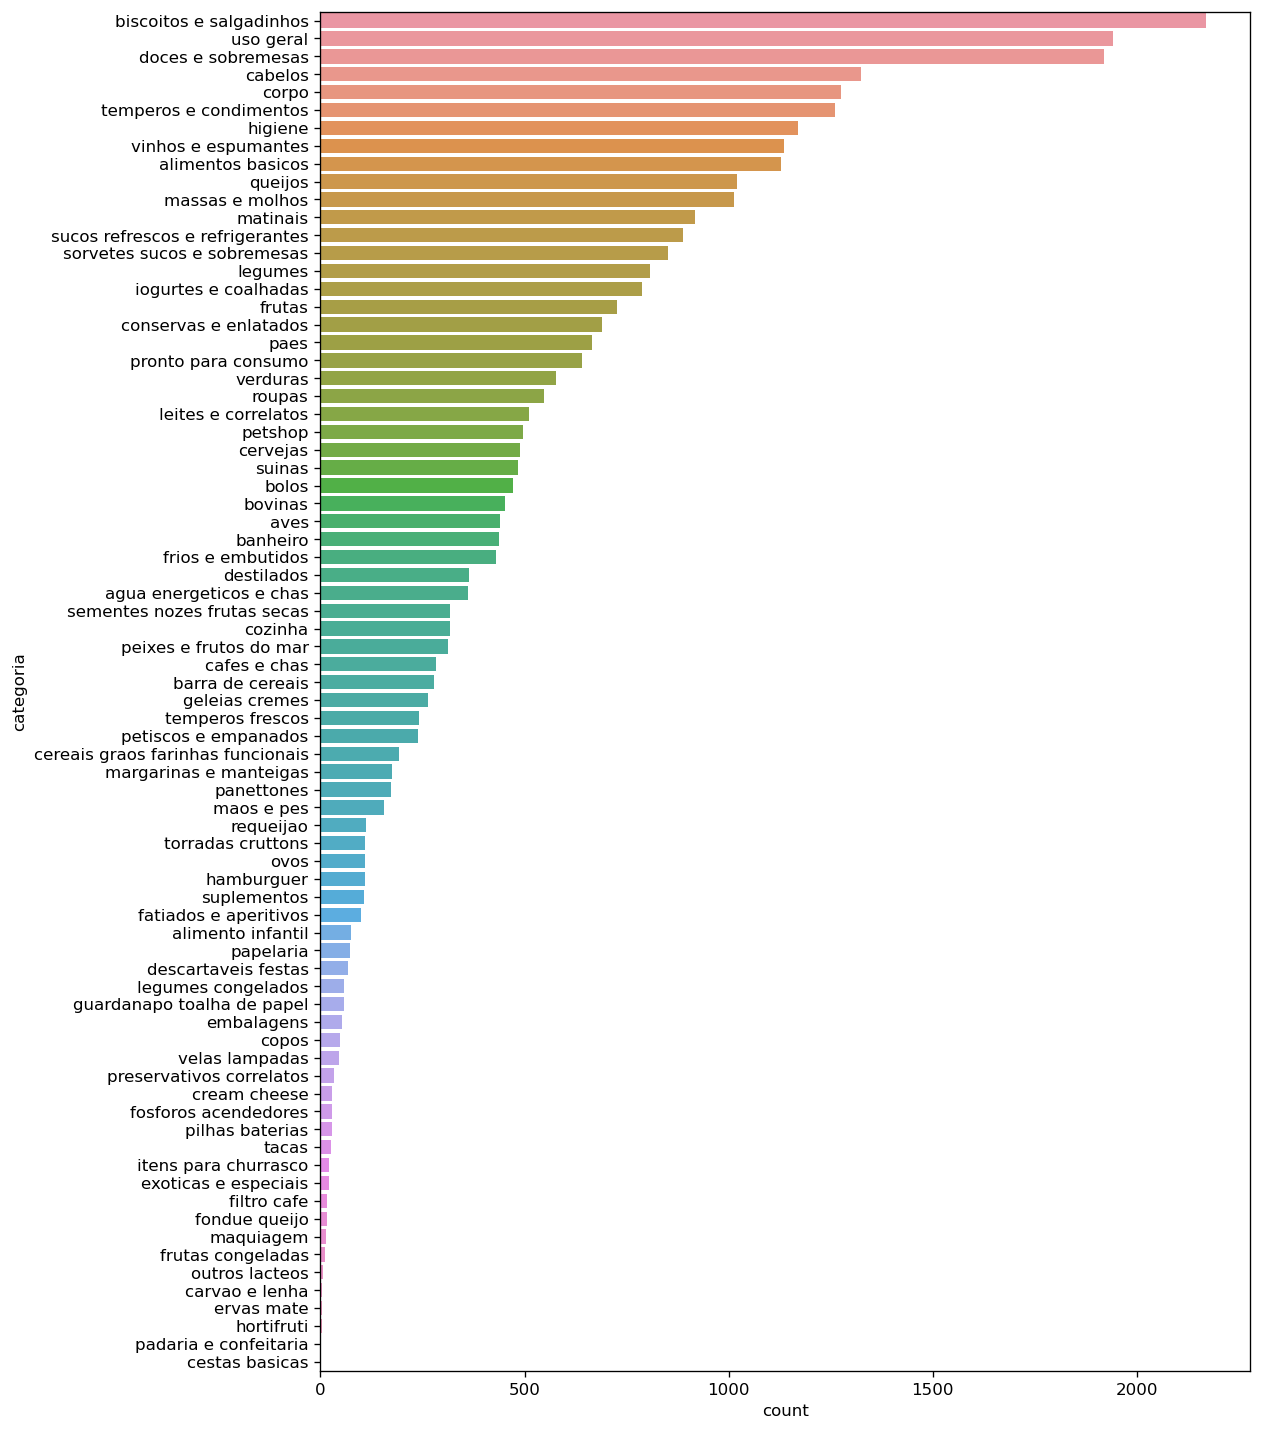

In [60]:
plt.figure(dpi=120,figsize=(10,15))
sns.countplot(data=df,y='categoria',order=df['categoria'].value_counts().index);

In [61]:
qt_minima = 6
df['categoria'].value_counts()[df['categoria'].value_counts() < qt_minima]

carvao e lenha           4
ervas mate               4
hortifruti               3
padaria e confeitaria    2
cestas basicas           1
Name: categoria, dtype: int64

Algumas categoria possuem muito poucos representantes, o que pode comprometer a qualidade da classificação. Vamos eliminar as categorias que tem menos de 6 produtos. Este valor foi escolihido porque o GridSearchCV, que usaremos mais a frente, por default cria 5 partições dos dados.

In [62]:
categorias = df['categoria'].value_counts()[df['categoria'].value_counts() < qt_minima].index

for categoria in categorias:
    indices = df[df['categoria'] == categoria].index
    df.drop(indices,inplace=True)

Vejamos se as categorias realmente foram derrubadas.

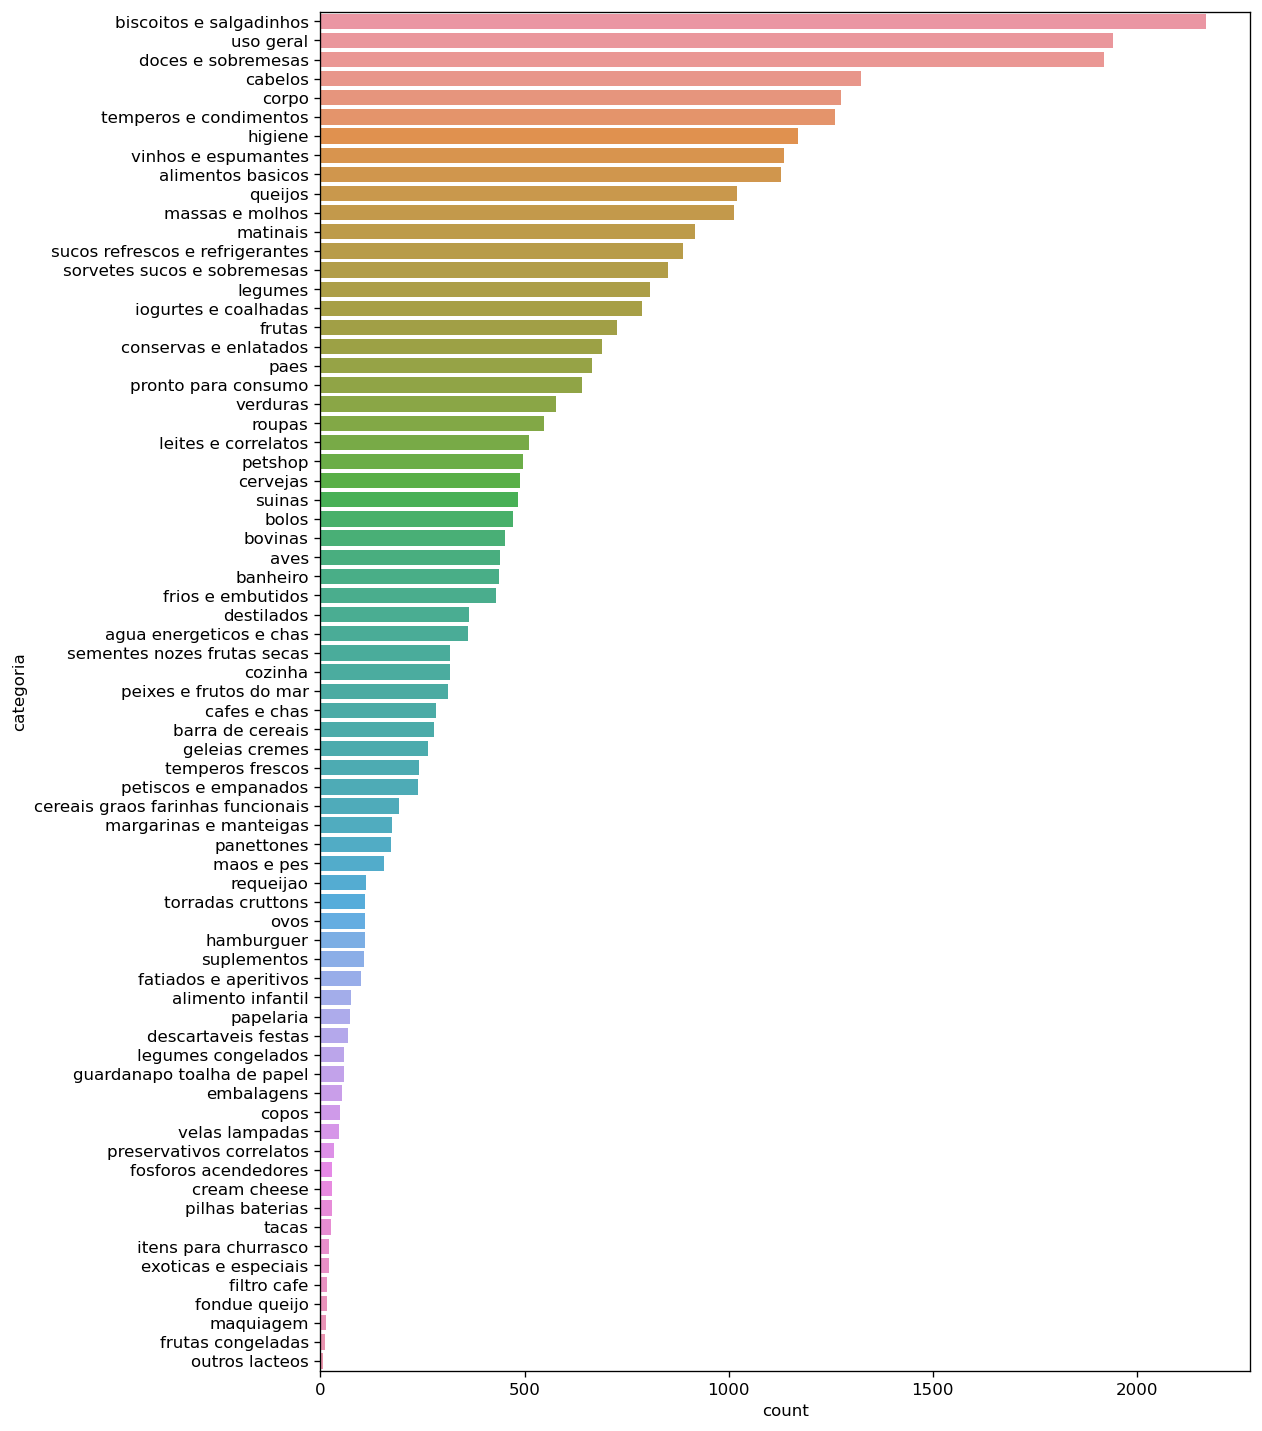

In [63]:
plt.figure(dpi=120,figsize=(10,15))
sns.countplot(data=df,y='categoria',order=df['categoria'].value_counts().index);

# Separação e preparação dos dados

Primeiramente vamos dividir nossos dados em X e y.

In [64]:
X = df['produto']
y = df['categoria']

Em seguida vamos separar nossos em dados em dados de treinamento, de teste e de avaliação final do modelo. Como usaremos validação cruzada, podemos reservar uma porção um pouco maior dos dados para treinamento. Separaremos os dados da segunte forma:
- 80% para treinamento;
- 10% para teste;
- 10% para avaliação final do modelo.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_holdout, X_test, y_holdout, y_test = train_test_split(X_test, y_test, test_size=0.5)

Vamos verificar o tamanho dos grupos para garantir que a separação se deu de forma correta.

In [66]:
print(f"Tamanho de X: {len(X)}")
print(f"Tamanho de y: {len(y)}")
print(f"Tamanho de X_train: {len(X_train)}")
print(f"Tamanho de y_train: {len(y_train)}")
print(f"Tamanho de X_test: {len(X_test)}")
print(f"Tamanho de y_test: {len(y_test)}")
print(f"Tamanho de X_holdout: {len(X_holdout)}")
print(f"Tamanho de y_holdout: {len(y_holdout)}")

Tamanho de X: 32724
Tamanho de y: 32724
Tamanho de X_train: 26179
Tamanho de y_train: 26179
Tamanho de X_test: 3273
Tamanho de y_test: 3273
Tamanho de X_holdout: 3272
Tamanho de y_holdout: 3272


Vamos vetorizar (contar as palavras, *criar uma bag of words*). Utilizaremos um método que, além de realizar a vetorização, também aplica TF-IDF, que atribui menor peso a palavras que se repetem mais vezes.<p>
Perceba que treinaremos o vetorizador somente com dados de treinamento para evitar qualquer tipo de vazamento de dados, ou seja, evitar que ele tenha acesso a dados de teste durante a fase de treinamento.

In [67]:
tfidf = TfidfVectorizer()
tfidf.fit(X_train) # Treinando o vetorizador
X_train_tfidf = tfidf.transform(X_train) # Poderíamos usar .fit_transform, mas separamos operaçõe p/ maior clareza.
X_test_tfidf = tfidf.transform(X_test)
X_holdout_tfidf = tfidf.transform(X_holdout)

# Treinamento, teste e avaliação de modelos
Antes de qualquer coisa, vamos criar uma função genéricas que irá nos mostrar métricas de performance do modelos que testaremos.

In [68]:
def reportar(model):
    y_pred = model.predict(X_test_tfidf)
    print(f"Melhores parâmetros: {model.best_params_}")
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

## Naive Bayes
Vamos treinar, testar e mensurar a performance de um modelo Naive Bayes por ele normalmente ser a melhor opção para NLP dada a sua agilidade. Utilizaremos grid search para descobrir o melhor valor para o hiper parâmetro *alpha*. Perceba que o modelo utilizado, GridSearchCV, executa grid search e validação cruzada ao mesmo tempo.<p>
Como temos algumas categorias com muito poucos produtos, algumas podem não ocorrer na massa de teste, o que levantará warnings. Para estas classes também não teremos métricas.

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3

Melhores parâmetros: {'alpha': 0}
                                   precision    recall  f1-score   support

          agua energeticos e chas       0.90      0.93      0.91        28
                alimento infantil       0.50      1.00      0.67         2
                alimentos basicos       0.86      0.86      0.86       118
                             aves       0.92      0.92      0.92        36
                         banheiro       0.90      0.88      0.89        40
                 barra de cereais       0.87      0.80      0.83        25
          biscoitos e salgadinhos       0.87      0.91      0.89       218
                            bolos       0.82      0.77      0.80        48
                          bovinas       0.93      0.85      0.89        48
                          cabelos       0.93      0.94      0.93       160
                     cafes e chas       0.92      0.95      0.93        37
cereais graos farinhas funcionais       0.75      0.68      0.71 

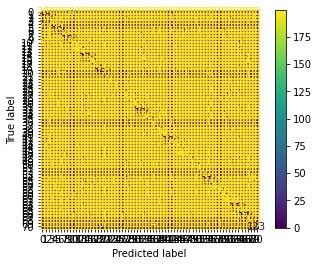

In [69]:
modelo_nb = MultinomialNB()
grid_nb = {'alpha':[0,0.25,0.5,0.75,1]}

modelo_grid_nb = GridSearchCV(estimator=modelo_nb,param_grid=grid_nb,scoring='accuracy')
modelo_grid_nb.fit(X_train_tfidf,y_train)
reportar(modelo_grid_nb)

O melhor valor para alpha foi 0, mas também recebemos alguns warnings de que alpha estava muito pequeno. Tal situação sugere um possivel fine tunning no nosso grid de parâmetros. Vamos realizá-lo.

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Melhores parâmetros: {'alpha': 0.01}
                                   precision    recall  f1-score   support

          agua energeticos e chas       0.93      0.93      0.93        28
                alimento infantil       0.50      1.00      0.67         2
                alimentos basicos       0.88      0.89      0.88       118
                             aves       0.89      0.94      0.92        36
                         banheiro       0.85      0.88      0.86        40
                 barra de cereais       0.85      0.92      0.88        25
          biscoitos e salgadinhos       0.91      0.91      0.91       218
                            bolos       0.82      0.77      0.80        48
                          bovinas       0.89      0.85      0.87        48
                          cabelos       0.96      0.97      0.97       160
                     cafes e chas       0.92      0.97      0.95        37
cereais graos farinhas funcionais       0.75      0.68      0.

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

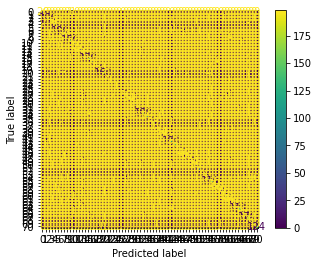

In [70]:
grid_nb = {'alpha':[0,1.0e-10,1.0e-5,0.01,0.05,0.1,0.2]}

modelo_grid_nb = GridSearchCV(estimator=modelo_nb,param_grid=grid_nb,scoring='accuracy')
modelo_grid_nb.fit(X_train_tfidf,y_train)
reportar(modelo_grid_nb)

O melhor valor para alpha passou a ser 0.01. Os valores de f1-score para as classes de a acurácia média estão bons. Podemos finalizar os treinamentos e testes do modelo.<p>
Vamos descobrir os valores finais de nosso modelo utilizando a massa de avaliação final, treinando-o com o melhor valor descoberto para alpha.

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

                                   precision    recall  f1-score   support

          agua energeticos e chas       0.97      0.91      0.94        32
                alimento infantil       0.83      1.00      0.91         5
                alimentos basicos       0.93      0.93      0.93       115
                             aves       0.92      0.91      0.91        53
                         banheiro       0.89      0.89      0.89        55
                 barra de cereais       0.83      1.00      0.91        20
          biscoitos e salgadinhos       0.93      0.92      0.93       207
                            bolos       0.92      0.80      0.86        45
                          bovinas       0.93      0.89      0.91        45
                          cabelos       0.95      0.96      0.95       128
                     cafes e chas       0.84      0.95      0.89        22
cereais graos farinhas funcionais       0.64      0.67      0.65        24
                        

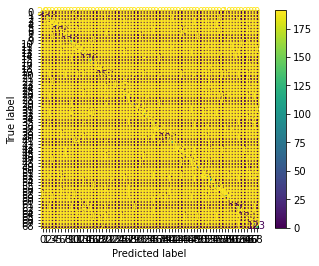

In [71]:
y_pred = modelo_grid_nb.predict(X_holdout_tfidf)
print(classification_report(y_holdout,y_pred))
cm = confusion_matrix(y_holdout,y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

A acurácia média é de 0.89 e o f1-score geral balanceado é de 0.89.

# Exportando o modelo
Além do modelo, também precisamos exportar o vetorizador TF-IDF. Antes disso, retreinaremos o modelo como dataset completo.

In [72]:
modelo_nb_final = MultinomialNB(alpha=0.01)

X_tfidf = tfidf.fit_transform(X)
modelo_nb_final.fit(X_tfidf,y)

joblib.dump(modelo_nb_final,'arquivos/modelos/modelo_nb_classificacao_categorias.pkl')
joblib.dump(tfidf,'arquivos/modelos/tfidf_classificacao_categorias.pkl')

['arquivos/modelos/tfidf_classificacao_categorias.pkl']

# Testando o modelo exportado

In [77]:
loaded_model = joblib.load('arquivos/modelos/modelo_nb_classificacao_categorias.pkl')
loaded_tfidf = joblib.load('arquivos/modelos/tfidf_classificacao_categorias.pkl')
teste = loaded_tfidf.transform(pd.Series(['cachaca artesnal']))
loaded_model.predict(teste)

array(['destilados'], dtype='<U33')